## Импорт библиотек

In [1]:
import numpy as np
from tqdm.auto import tqdm, trange
import torch
from torch import nn
from torch.utils.data import Dataset, Subset, DataLoader
import torchvision.transforms as tr
import torch.nn.functional as F
from torchvision import datasets
from collections import Counter, OrderedDict
from IPython.display import clear_output
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
import seaborn as sns
%matplotlib inline

## Загрузка и визуализация данных

In [2]:
data = {}

data['train'] = datasets.CIFAR10(root='./data', download=True, train=True)
data['test'] = datasets.CIFAR10(root='./data', download=True, train=False)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
train_size = len(data['train'])
test_size = len(data['test'])
print(f'train size: {train_size}')
print(f'test size: {test_size}')

classes = data['train'].classes
classes_ = '\n    '.join(classes)
print(f'{len(classes)} classes:\n    {classes_}')

img = data['train'][0][0]
img_size = [len(img.getbands()), *img.size]
print(f'images of shape: {img_size}')

train size: 50000
test size: 10000
10 classes:
    airplane
    automobile
    bird
    cat
    deer
    dog
    frog
    horse
    ship
    truck
images of shape: [3, 32, 32]


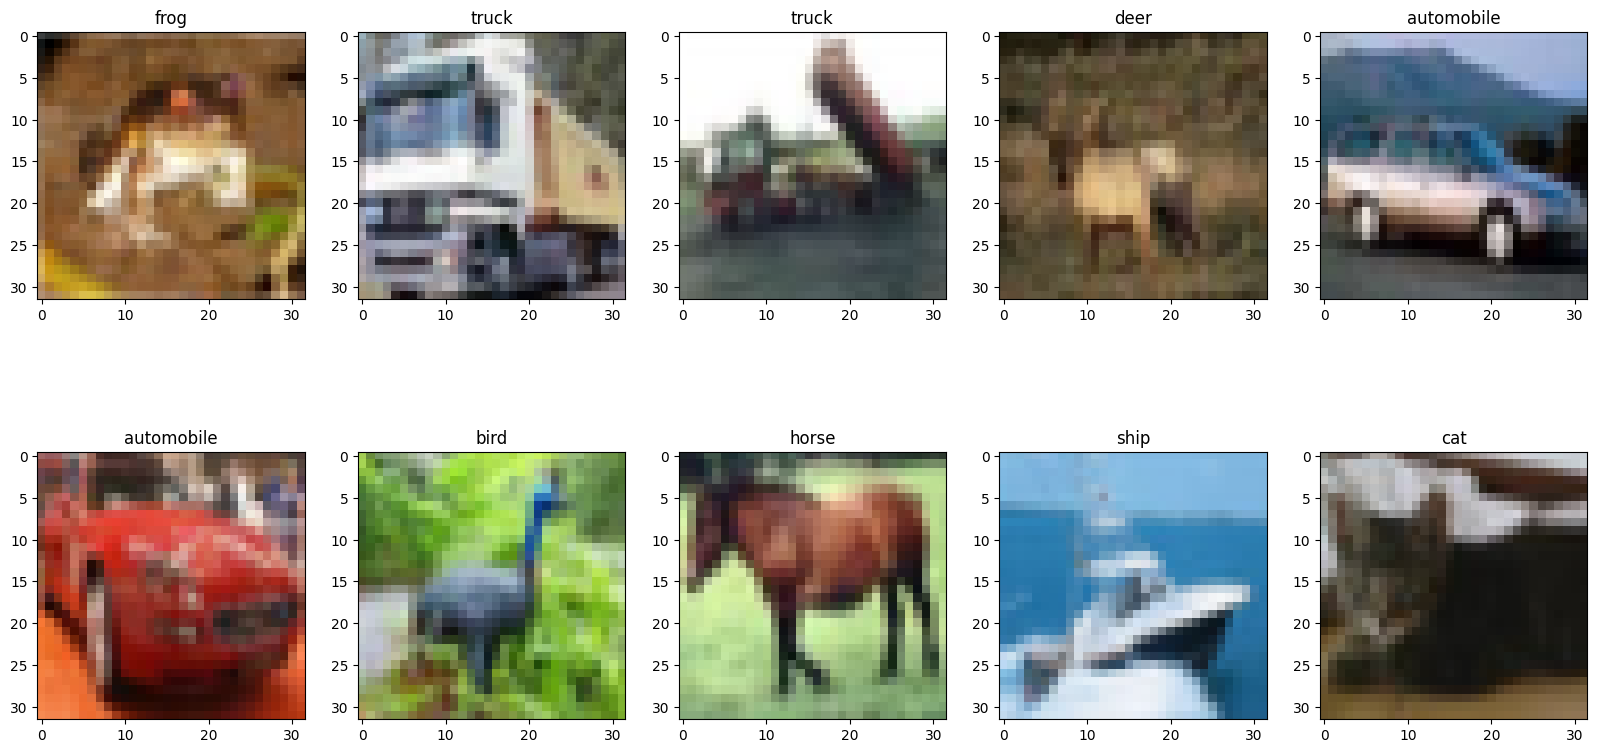

In [4]:
fig, ax = plt.subplots(2, 5, figsize=(20, 10))
for i, el in enumerate(data["train"]):
    if i >= 10:
        break
    plt.subplot(2, 5, i + 1)
    plt.imshow(el[0])
    plt.title(data["train"].classes[el[1]])
plt.show()

## Dataset, Dataloader, разделение данные на train/val/test и визуализация распределения классов для каждой выборки

In [5]:
channel_mean = np.zeros((img_size[0]))
channel_std = np.zeros((img_size[0]))

for img, _ in tqdm(data['train']):
    img = np.array(img) / 255.
    channel_mean += img.mean(axis=(0, 1))
    channel_std += img.std(axis=(0, 1))

channel_mean /= len(data['train'])
channel_std /= len(data['train'])

print(channel_mean, channel_std)

  0%|          | 0/50000 [00:00<?, ?it/s]

[0.49139968 0.48215841 0.44653091] [0.20220212 0.19931542 0.20086346]


In [6]:
class AddTransformsDataset(Dataset):
    def __init__(self, dataset, transforms=None, indices=None):
        if indices is not None:
            self.dataset = Subset(dataset, indices)
        else:
            self.dataset = dataset
        self.transforms = transforms
    
    def __len__(self) -> int:
        return self.dataset.__len__()
    
    def __getitem__(self, index: int):
        image, label = self.dataset.__getitem__(index)
        if self.transforms:
            image = self.transforms(image)
        return image, label

К данным применяем нормализацию (поканальное среднее и стандартное отклонение), а также используем горизонтальное отражение в качестве аугментации для увеличения обучающей выборки

In [7]:
def train_transform():
    return tr.Compose([
        tr.RandomHorizontalFlip(0.5),
        tr.ToTensor(),
        tr.Normalize(channel_mean, channel_std),
    ])

def val_transform():
    return tr.Compose([
        tr.ToTensor(),
        tr.Normalize(channel_mean, channel_std),
    ])


def make_dataloaders(
    data,
    batch_size=16,
    train_transform_function=None,
    val_transform_function=None,
    val_part=0.5,
    num_workers=0,
):
    dataloaders = dict()
    
    ds_train = AddTransformsDataset(data['train'], train_transform_function())
    dataloaders['train'] = DataLoader(
        ds_train,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
        num_workers=num_workers,
    )
    
    perm = torch.randperm(len(data['test']))
    val_size = round(len(data["test"]) * val_part)
    
    
    ds_val = AddTransformsDataset(data['test'], val_transform_function(), perm[:val_size])
    dataloaders['val'] = DataLoader(
        ds_val,
        batch_size=batch_size,
        shuffle=False,
        drop_last=False,
        num_workers=num_workers,
    )
    
    ds_test = AddTransformsDataset(data['test'], val_transform_function(), perm[val_size:])
    dataloaders['test'] = DataLoader(
        ds_test,
        batch_size=batch_size,
        shuffle=False,
        drop_last=False,
        num_workers=num_workers,
    )
    
    return dataloaders


dataloaders = make_dataloaders(
    data,
    batch_size=64,
    train_transform_function=train_transform,
    val_transform_function=val_transform,
    val_part=0.5,
    num_workers=0,
)

print(f'train size: {len(dataloaders['train'].dataset)}')
print(f'validation size: {len(dataloaders['val'].dataset)}')
print(f'test size: {len(dataloaders['test'].dataset)}')

train size: 50000
validation size: 5000
test size: 5000


Все классы изображений равномерно представлены в каждой выборке

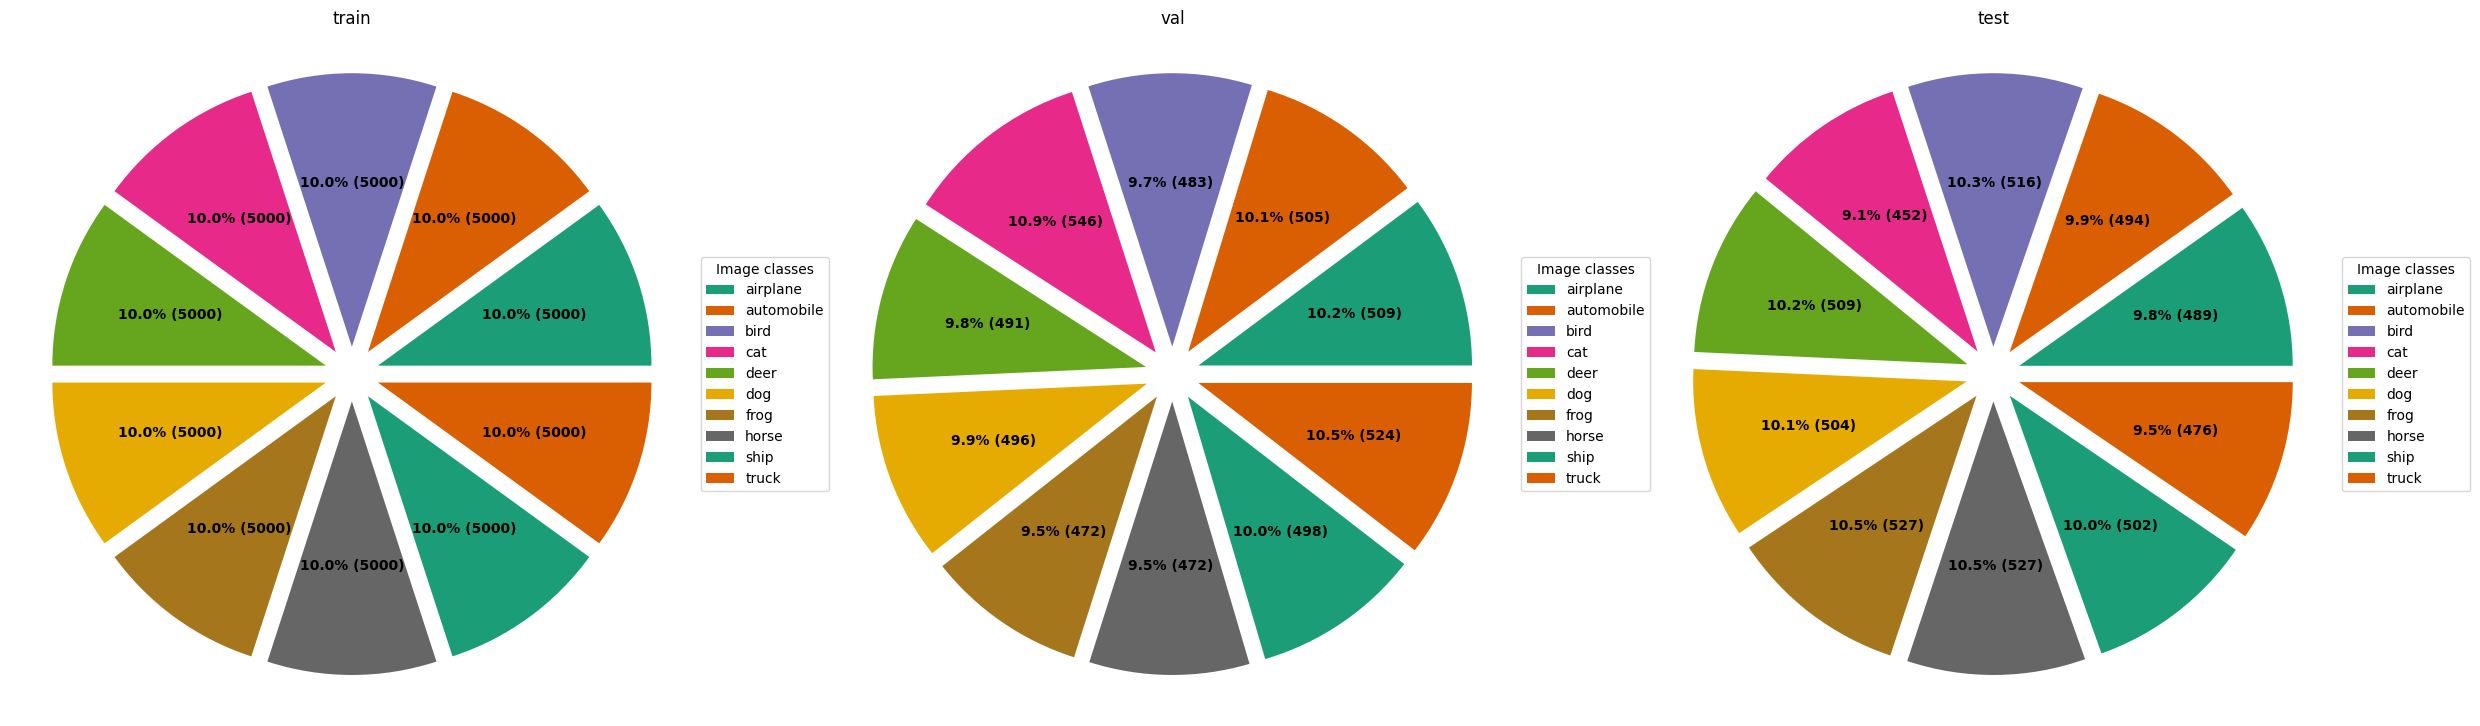

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(30, 20))
for i, split in enumerate(dataloaders):
    plt.subplot(1, 3, i+1)
    plt.title(split)
    size = len(dataloaders[split].dataset)
    cnt = Counter([dataloaders[split].dataset[i][1]
                   for i in range(size)])
    wedges, texts, autotexts = plt.pie(
        [cnt[j] for j in range(len(classes))],
        autopct=lambda pct: '{:.1f}% ({:d})'.format(pct, int(pct/100.*size)),
        textprops=dict(color="black"),
        colors=plt.cm.Dark2.colors,
        startangle=0,
        explode=[0.1]*len(classes),
    )
    plt.legend(wedges, classes, title='Image classes', loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
    plt.setp(autotexts, size=10, weight=700)
plt.show()

## Архитектура модели

Для модели была выбрана сверточная сеть с ResNet-подобной архитектурой, основанной на ResidualBlock-ах, позволяющих избежать затухания градиентов за счет skip-connections.


Эта архитектура - облегченное подобие классической для подобных задач (классификации изображений) архитектуры ResNet. Применение даже ResNet-18 для классификации CIFAR-10 я посчитал избыточным.

Краткое описание архитектуры:
    
    Redsidual блоки за счет сверток извлекают признаки из изображения
    
    Число каналов увеличивается с глубиной сети (64 - 128 - 256) для извлечения более сложных признаков и построения иерархии признаков

    Пулинг спрямляет карту признаков в вектор перед классификацией

    В конце, в классификационной голове применяется DropOut для регуляризации, затем Linear слой классификации, который из 256 делает 10 признаков (по числу классов), а уже LogSoftmax отображает признаки в логарифмы вероятностей классов

In [9]:
class ResidualBlock(nn.Module):
    def __init__(self, input_channels, output_channels, downsampling=False):
        super(ResidualBlock, self).__init__()

        if downsampling:
            stride_value = 2
        else:
            stride_value = 1
        
        self.block = nn.Sequential(
            nn.Conv2d(input_channels, output_channels, kernel_size=3, stride=stride_value, padding=1),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(output_channels, output_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(output_channels)
        )

        if input_channels == output_channels and not downsampling:
            self.projection = nn.Identity()
        else:
            self.projection = nn.Conv2d(input_channels, output_channels, kernel_size=1, stride=stride_value)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.projection(x) + self.block(x)
        x = self.relu(x)
        return x


class ConvNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(ConvNet, self).__init__()

        self.init_conv = nn.Sequential(
            nn.Conv2d(input_size[0], 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.res_blocks = nn.Sequential(
            ResidualBlock(64, 64),
            ResidualBlock(64, 128, downsampling=True),
            ResidualBlock(128, 128),
            ResidualBlock(128, 256, downsampling=True),
            ResidualBlock(256, 256)
        )

        self.pooling = nn.AdaptiveAvgPool2d(1)
        self.head = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256, output_size),
            nn.LogSoftmax(dim=-1)
        )

    def forward(self, x):
        x = self.init_conv(x)
        x = self.res_blocks(x)
        x = self.pooling(x).flatten(1)
        return self.head(x)

In [10]:
model = ConvNet(
    input_size = img_size,
    output_size = len(classes)
)
model

ConvNet(
  (init_conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (res_blocks): Sequential(
    (0): ResidualBlock(
      (block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (projection): Identity()
      (relu): ReLU(inplace=True)
    )
    (1): ResidualBlock(
      (block): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2)

## Проверяем размерности того, что поступает на вход модели и что получается на выходе

In [11]:
imgs_batch, labels_batch = next(iter(dataloaders['train']))

print(f'input shape: {imgs_batch.shape}')
print(f'output shape: {model(imgs_batch).shape}')

input shape: torch.Size([64, 3, 32, 32])
output shape: torch.Size([64, 10])


## Model & Optimizer

В качестве оптимизатора был выбран Adam (классический выбор). Изначально думал применить scheduler для изменения learning rate, но решил в итоговую модель не использовать, так как решил, что это избыточно для данной задачи.

In [12]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def create_model_and_optimizer(model_class, model_params, lr=1e-2, beta1=0.9, beta2=0.999, device=device):
    model = model_class(**model_params)
    model = model.to(device)
    
    params = []
    for param in model.parameters():
        if param.requires_grad:
            params.append(param)
    
    optimizer = torch.optim.Adam(params, lr, [beta1, beta2])
    return model, optimizer

In [13]:
model_params = {
    'input_size': img_size,
    'output_size': len(classes),
}

model, optimizer = create_model_and_optimizer(
    model_class = ConvNet, 
    model_params = model_params,
    lr = 1e-3,
    device = device,
)

scheduler = None
criterion = nn.NLLLoss()

losses = dict()
metrics = dict()

## Фукнции эпохи обучения и эпохи валидации

In [14]:
def train_epoch(model, optimizer, loader, criterion):
    model.train()
    losses_tr = []
    for images, targets in tqdm(loader):
        images = images.to(device)
        targets = targets.to(device)
        
        optimizer.zero_grad()
        out = model(images)
        loss = criterion(out, targets)
        
        loss.backward()
        optimizer.step()
        losses_tr.append(loss.item())
    
    return model, optimizer, np.mean(losses_tr)


def val_epoch(model, loader, criterion):
    model.eval()
    losses_val = []
    metrics = {'accuracy': []}
    
    with torch.no_grad():
        for images, targets in tqdm(loader):
            images = images.to(device)
            targets = targets.to(device)
            out = model(images)
            loss = criterion(out, targets)
            losses_val.append(loss.item())
            
            _, pred_classes = torch.max(out, dim=-1)
            metrics['accuracy'].append((pred_classes == targets).float().mean().item())
    
        metrics['accuracy'] = np.mean(metrics['accuracy'])
    
    return np.mean(losses_val), metrics

## Цикл обучения

In [15]:
def learning_loop(model, optimizer, train_loader, val_loader, criterion, scheduler=None, epochs=10, val_every=1, draw_every=1):
    losses = {'train': [], 'val': []}
    metrics = {'accuracy': []}

    for epoch in range(1, epochs+1):
        print(f'#{epoch}/{epochs}:')
        model, optimizer, loss = train_epoch(model, optimizer, train_loader, criterion)
        losses['train'].append(loss)

        if not (epoch % val_every):
            loss, metrics_ = val_epoch(model, val_loader, criterion)
            losses['val'].append(loss)
            metrics['accuracy'].append(metrics_['accuracy'])
                    
            if scheduler:
                try:
                    scheduler.step()
                except:
                    scheduler.step(loss)

        if not (epoch % draw_every):
            clear_output(True)
            fig, ax = plt.subplots(1, 2, figsize=(20, 10))
            fig.suptitle(f'#{epoch}/{epochs}:')

            plt.subplot(1, 2, 1)
            plt.title('losses')
            plt.plot(losses['train'], 'r.-', label='train')
            plt.plot(losses['val'], 'g.-', label='val')
            plt.legend()
            
            plt.subplot(1, 2, 2)
            plt.title('metrics')
            plt.plot(metrics['accuracy'], '.-', label='accuracy')
            plt.legend()
            
            plt.show()
    
    return model, optimizer, losses, metrics

## Обучение модели

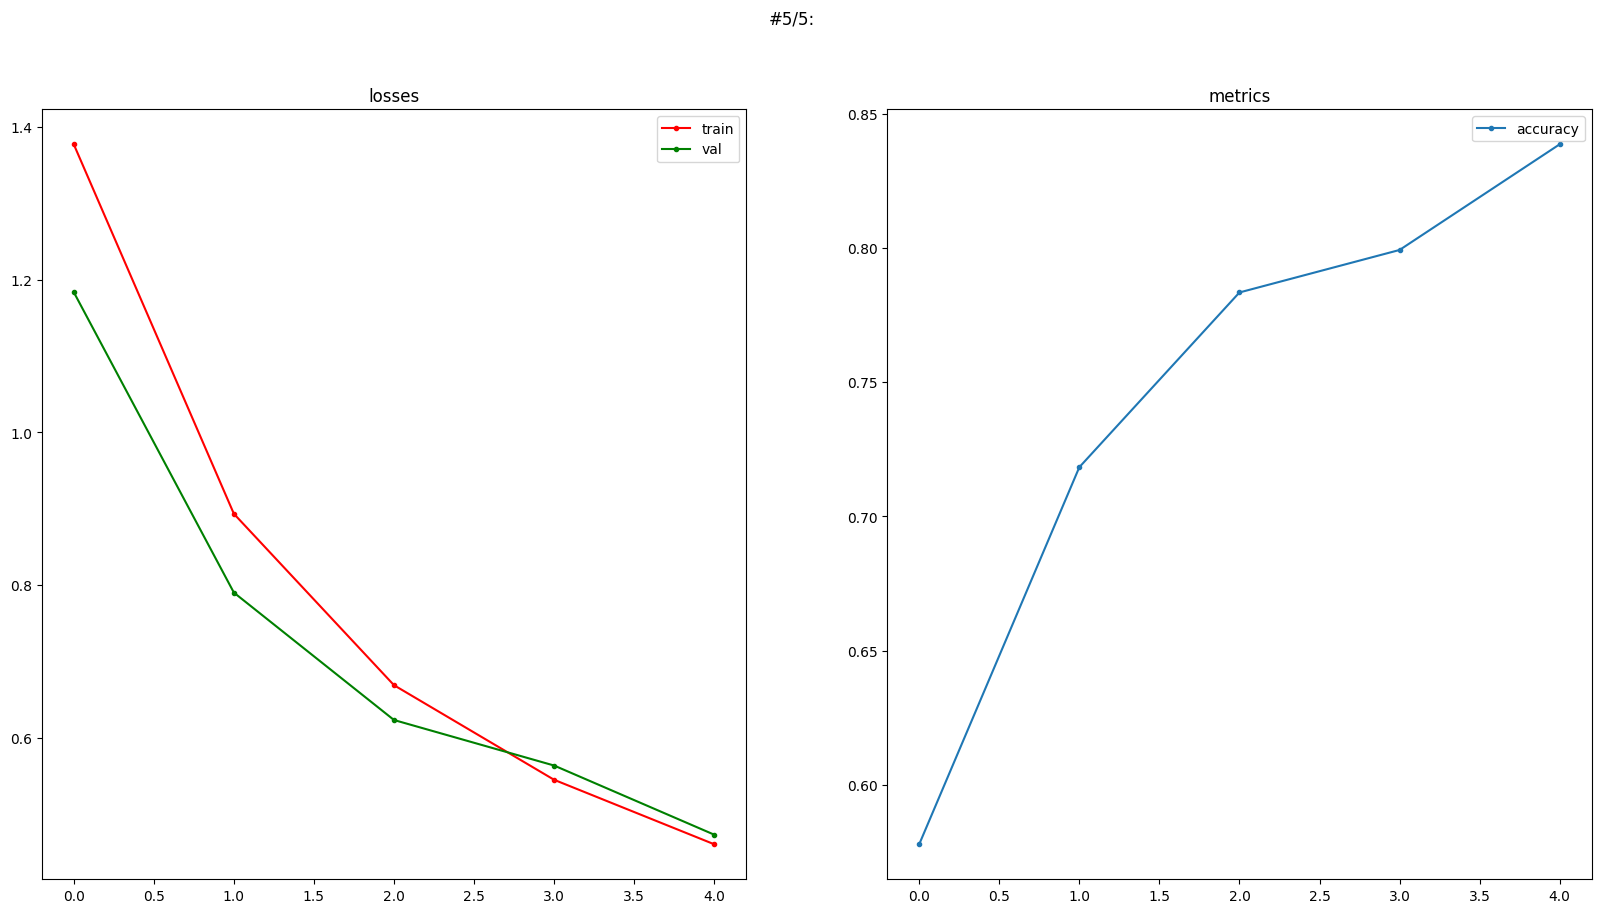

CPU times: total: 5h 36min 31s
Wall time: 2h 35min 29s


In [16]:
%%time
model, optimizer, loss, metrics = learning_loop(
    model = model,
    optimizer = optimizer,
    train_loader = dataloaders['train'],
    val_loader = dataloaders['val'],
    criterion = criterion,
    scheduler = scheduler,
    epochs = 5,
)

## Метрики (Accuracy и поклассовый F1) на test

In [17]:
model.eval()
accuracy = []
all_preds = []
all_targets = []


with torch.no_grad():
    for images, targets in dataloaders['test']:
        images = images.to(device)
        targets = targets.to(device)

        out = model(images)
        _, pred_classes = torch.max(out, dim=-1)
        accuracy.append((pred_classes == targets).float().mean().item())
        all_preds.append(pred_classes.cpu())
        all_targets.append(targets.cpu())

all_preds = torch.cat(all_preds).numpy()
all_targets = torch.cat(all_targets).numpy()
f1 = f1_score(all_targets, all_preds, average=None)


print("Test Accuracy:", np.mean(accuracy))

for class_idx, score in enumerate(f1):
    print(f"Test F1-score for class {classes[class_idx]}: {score}")


Test Accuracy: 0.8421677215189873
Test F1-score for class airplane: 0.8398791540785498
Test F1-score for class automobile: 0.9131707317073171
Test F1-score for class bird: 0.8059701492537313
Test F1-score for class cat: 0.6896551724137931
Test F1-score for class deer: 0.8105726872246696
Test F1-score for class dog: 0.794921875
Test F1-score for class frog: 0.8851540616246498
Test F1-score for class horse: 0.8761552680221811
Test F1-score for class ship: 0.9151219512195122
Test F1-score for class truck: 0.8879120879120879


## Сохранение весов модели и сохранение полной модели

In [18]:
torch.save(model.state_dict(), "ConvNet_weights.pth")

torch.save(model, "ConvNet.pth")

## Матрица ошибок (смотрим ошибки классификации, где модель ошибается)

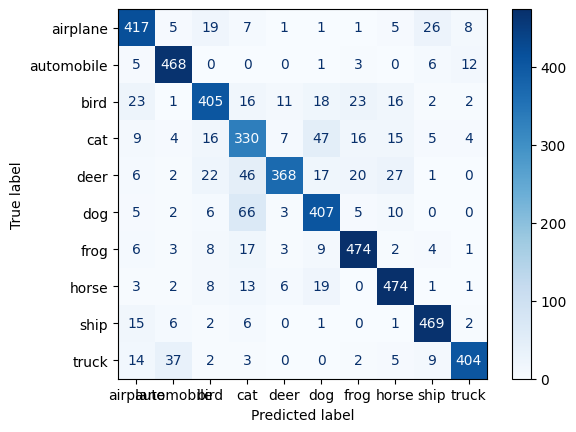

In [19]:
all_preds = []
all_targets = []

model.eval()
with torch.no_grad():
    for images, targets in dataloaders['test']:
        images = images.to(device)
        targets = targets.to(device)

        out = model(images)
        _, pred_classes = torch.max(out, dim=-1)

        all_preds.append(pred_classes.cpu())
        all_targets.append(targets.cpu())

all_preds = torch.cat(all_preds).numpy()
all_targets = torch.cat(all_targets).numpy()

cm = confusion_matrix(all_targets, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

## Визуализация примеров misclassified изображений

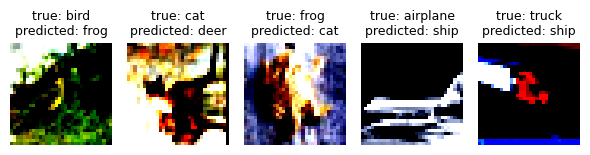

In [20]:
model.eval()
misclassified_images = []
misclassified_preds = []
misclassified_targets = []

with torch.no_grad():
    for images, targets in dataloaders['test']:
        images = images.to(device)
        targets = targets.to(device)

        out = model(images)
        _, pred_classes = torch.max(out, dim=-1)

        mismatches = pred_classes != targets
        
        misclassified_images.append(images[mismatches])
        misclassified_preds.append(pred_classes[mismatches])
        misclassified_targets.append(targets[mismatches])


misclassified_images = torch.cat(misclassified_images)
misclassified_preds = torch.cat(misclassified_preds)
misclassified_targets = torch.cat(misclassified_targets)

n = 5  # число примеров
plt.figure(figsize=(6, 4))

for i in range(n):
    plt.subplot(1, 5, i+1)
    img = misclassified_images[i].cpu().numpy()
    img = np.transpose(img, (1, 2, 0))
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    true_label = classes[misclassified_targets[i]]
    pred_target = classes[misclassified_preds[i]]
    plt.title(f"true: {true_label}\npredicted: {pred_target}", fontsize=9)
    plt.axis('off')

plt.tight_layout()
plt.show()